In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip

In [15]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!unzip DIV2K_valid_HR.zip

--2020-12-08 08:18:31--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip [following]
--2020-12-08 08:18:32--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip’

DIV2K_valid_HR.zip  100%[===================>] 428.19M  9.74MB/s    in 44s     

2020-12-08 08:19:17 (9.65 MB/s) - ‘DIV2K_valid_HR.zip’ saved [448993893/448993893]

Archive:  DIV2K_valid_HR.zip
   creating: DIV2K_valid_HR/
  inflating: DIV2K_valid_HR/0897.png  
  inflating: DIV2K_valid_HR/0887.png  
  inflat

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
!unzip DIV2K_train_LR_bicubic_X2

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X3.zip
!unzip DIV2K_train_LR_bicubic_X3

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
!unzip DIV2K_train_LR_bicubic_X4

#Laplacian Frequency Representation

In [29]:
from collections import namedtuple
import math

# Level object which contains information about the index, scale and size ( given the patch size ) of the pyramid level representation
Level = namedtuple("Level", "index scale size")

class LaplacianFrequencyRepresentation:
  """Define a Laplacian Frequency Representation class wwhich holds information and method for handling indices,scales and sizes inside the pyramid levels.

  Args:
    start: starting of the Laplacian Frequency Representation range
    end: ending of the Laplacian Frequency Representation range
    count: amount of LEVELS inside the laplacian frequency representation ( included the first one where no scaling is done; e.g with start = 1, the first scale is 1.0 )
    patch_size: Patch input size of the ASDN network before the bicubic interpolation

  Attributes:
    count: amount of LEVELS inside the laplacian frequency representation ( included the first one where no scaling is done; e.g with start = 1, the first scale is 1.0 )
    information: List of Level(index,scale,size) tuples that hold information for each level of the Laplacian Frequency Representation
  """
  def __init__(self, start: int,end : int,count : int, patch_size : int):
    
    self.start = start
    self.end = end
    self.count = count

    # if numpy is availablbe use np.linspace(start,end,count)
    # otherwise
    step = (end - start) / (count - 1) 
    scales = [start + l*step for l in range(count)]
    sizes  = [math.floor(patch_size * scale) for scale in scales]
    
    self.information = [ Level(index,scale,size) for index,(scale,size) in enumerate(zip(scales,sizes)) ]

  def get_index(self, scale):
    """ Return the corresponding pyramid index for the given decimal scale
    Args:
      scale: Decimal scale
    Returns:
      index
    """
    return math.ceil((self.count - 1) * (scale - 1))

  def get_weight(self,scale):
    """ Return the interpolation weight for the given decimal scale
    Args:
      scale: Decimal scale
    Returns:
      weight
    """
    return (self.count - 1) * (self.information[self.get_index(scale)].scale - scale)

  def get_for(self,scale):
    index = self.get_index(scale)
    return self.information[index-1], self.information[index] 

# Define Dataset for *Pytorch*

## Normalize Inverse

In [30]:
import torch
from torchvision.transforms import transforms
from typing import List

class NormalizeInverse(transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

## ASDNDataset

In [45]:
import random
import pickle

from torch.nn.functional import interpolate
from torch.utils.data import Dataset,DataLoader
from typing import Union
from pathlib import Path

import PIL

class ASDNDataset(Dataset):
  """Define the Dataset class used for constructing batches for ASDN network

  NOTE: In the paper is not clear how targets are created therefore this will be my pipeline:
  * 1. Crop a high-res patch with size (patch_size * end, patch_size * end)
  * 2. Create ground truth resizing using the best algorithm
  * 3. Create low-res patch resize using worst algorithm 

  Args:
    folder: relative or absolute path or Path object where images are stored
    patch_size: Input patch size (before interpolation )
    lfr: Laplacian Frequency Representation object that stores information of the pyramid
    mean: list of float containing the mean value of each channel
    std: list of float containing the std value of each channel
    mean_std_filename: relative or absolute path of dictionary serialized as a pickle-file that contains mean and std values
    augmentation: Transformations for augmenting the dataset 
  """
    
  def __init__(self, 
               folder : Union[str,Path], 
               patch_size : int,
               lfr : LaplacianFrequencyRepresentation,
               mean:List[float] = None, std:List[float] = None, mean_std_filename : str = None, 
               augmentation = None):
    

    if isinstance(folder,str):
      folder = Path(folder)
    
    if not folder.exists:
      raise FileNotFoundError(f"Folder {folder} doesn't exist.")
    
    if mean_std_filename is not None:
      pickle_file = folder / mean_std_filename
      if not pickle_file.exists():
        raise FileNotFoundError(f"Can't find {pickle_file}")
      else:
        with open(pickle_file, 'rb') as file:
          dict_mean_std = pickle.load(file)
          self.mean = dict_mean_std["mean"]
          self.std  = dict_mean_std["std"]
    else:
      if mean is None and std is not None:  
        raise RuntimeError("Provide mean.")
      elif mean is not None and std is None:
        raise RuntimeError("Provide std.")
      elif mean is None and std is None:
        # apply my values
        mean_std_dict = {'mean': [0.4484562277793884, 0.4374960660934448, 0.40452802181243896], 'std': [0.2436375468969345, 0.23301854729652405, 0.24241816997528076]}
        self.mean = mean_std_dict['mean']
        self.std  = mean_std_dict['std']
      else:
        self.mean = mean
        self.std  = std
    
    self.get_high_res_crop = transforms.Compose([
                                         transforms.ToTensor(), 
                                         transforms.Normalize(self.mean,self.std),
                                         transforms.RandomCrop(patch_size*lfr.end),  
                                         ])
    
    self.resize_functions = [ transforms.Resize((level.size,level.size), interpolation=PIL.Image.BICUBIC) for level in lfr.information]
    
    self.resize_high_res_to_low_res = transforms.Resize((patch_size,patch_size), interpolation=PIL.Image.NEAREST)

    self.augmentation = augmentation

    self.files = list(folder.glob("*.png"))


  def __getitem__(self,index):
    high_res_image = PIL.Image.open(self.files[index])
    
    # create high res crop which is the input 
    high_res_crop  = self.get_high_res_crop(high_res_image)

    # free resoures
    high_res_image.close()
    del     high_res_image

    # apply augmentation
    if self.augmentation:
      high_res_crop = self.augmentation(high_res_crop)
    
    # extract LR patch (as input)
    low_res_crop   = self.resize_high_res_to_low_res(high_res_crop)

    # extract ground truth
    laplacian_pyramid_ground_truth = [ resize_fn(high_res_crop) for resize_fn in self.resize_functions ]

    return low_res_crop, laplacian_pyramid_ground_truth

  def __len__(self):
    return len(self.files)

  @staticmethod
  def collate(batch, lfr):
    # sample a random value between 1 and 2 using an uniform distribution 
    # scale value that will be used for all the batch
    scale = random.uniform(lfr.start,lfr.end) 
    level_i_minus_1, level_i = lfr.get_for(scale)
    
    input, pyramid_batch = zip(*batch)
    
    # create the input batch
    low_res_batch = torch.stack(input)
    
    # interpolated the LR input for forwarding correctly inside the network
    low_res_batch_i = interpolate(low_res_batch,scale_factor=level_i.scale, mode='bicubic',recompute_scale_factor=False, align_corners=False)
    low_res_batch_i_minus_1 = interpolate(low_res_batch,scale_factor=level_i_minus_1.scale, mode='bicubic', recompute_scale_factor=False, align_corners=False)

    # create the ground truth for the loss
    pyramid_i = []
    pyramid_i_minus_1 = []

    for elem in pyramid_batch:
      assert isinstance(elem,list)
      laplacian_i         = elem[level_i.index]
      laplacian_i_minus_1 = elem[level_i_minus_1.index]
      pyramid_i.append(laplacian_i)
      pyramid_i_minus_1.append(laplacian_i_minus_1)
    
    pyramid_i = torch.stack(pyramid_i)
    pyramid_i_minus_1 = torch.stack(pyramid_i_minus_1)

    
    return (low_res_batch_i_minus_1, pyramid_i_minus_1), (low_res_batch_i, pyramid_i) 

# Test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground truth i')

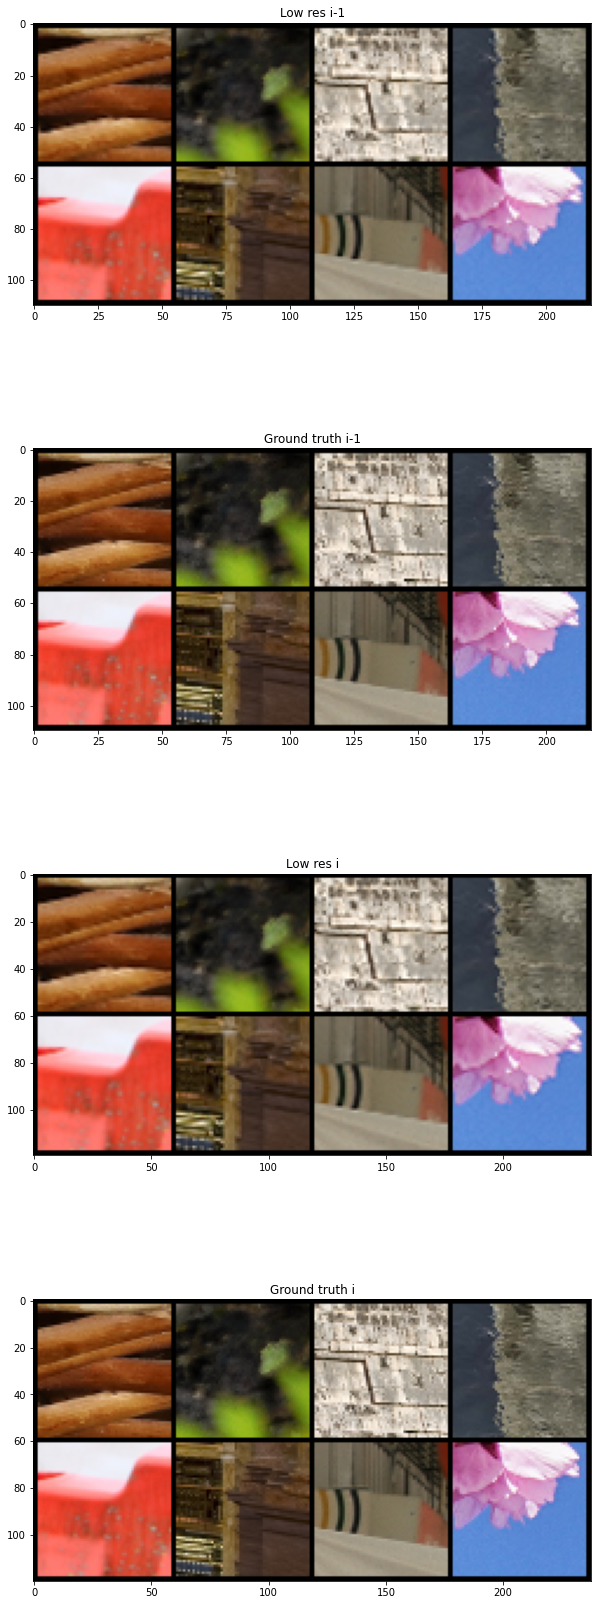

In [48]:
from functools import partial
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

START,END,COUNT = 1,2,11

PATCH_SIZE = 48

BATCH_SIZE = 8

NUM_WORKERS = 4

LFR = LaplacianFrequencyRepresentation(START,END,COUNT,PATCH_SIZE)

COLLATE_FN = partial(ASDNDataset.collate, lfr=LFR)

dataset    = ASDNDataset("DIV2K_valid_HR", patch_size=PATCH_SIZE, lfr=LFR)

dataloader = DataLoader(dataset,num_workers=NUM_WORKERS, batch_size=BATCH_SIZE,pin_memory=True, collate_fn = COLLATE_FN)

for index, ( (low_res_batch_i_minus_1, pyramid_i_minus_1), (low_res_batch_i, pyramid_i) )  in enumerate(tqdm(dataloader)):
  if index == 0:
    break

denormalize = NormalizeInverse(dataset.mean,dataset.std)
low_res_batch_i_minus_1 = denormalize(low_res_batch_i_minus_1)
pyramid_i_minus_1     = denormalize(pyramid_i_minus_1)

low_res_batch_i     = denormalize(low_res_batch_i)
pyramid_i     = denormalize(pyramid_i)


MAX_IMAGES = 16
N_ROW      = 4

plt.figure(figsize=(10,30))

plt.subplot(411)
plt.imshow(make_grid(low_res_batch_i_minus_1[:MAX_IMAGES],nrow=N_ROW).permute(1,2,0))
plt.title("Low res i-1")

plt.subplot(412)
plt.imshow(make_grid(pyramid_i_minus_1[:MAX_IMAGES],nrow=N_ROW).permute(1,2,0))
plt.title("Ground truth i-1")

plt.subplot(413)
plt.imshow(make_grid(low_res_batch_i[:MAX_IMAGES],nrow=N_ROW).permute(1,2,0))
plt.title("Low res i")

plt.subplot(414)
plt.imshow(make_grid(pyramid_i[:MAX_IMAGES],nrow=N_ROW).permute(1,2,0))
plt.title("Ground truth i")
